In [1]:
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Get data, 数据增强，在5-1中筛选了数据进行补充，其余作为测试数据

In [3]:
# 获取数据，看COD和总氮的范围
data = np.load('./databygroup.npy',allow_pickle=True).tolist()

TrainData,TestData={},{}
for k in data.keys():
    TrainData[k]=data[k]
    TestData[k]=data[k]
        
#Tdata=TrainData[TrainData.keys()]
step=20
xtrain,ytrain=[],[]
for k in TrainData.keys():
    for i in range(int(0.8*TrainData[k].shape[0])-step-1):
        xtrain.append(TrainData[k][i:i+step,:TrainData[k].shape[1]-5].tolist())
        ytrain.append(TrainData[k][i+1+step,[-5,-4,-3,-2,-1]].tolist())

xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

In [4]:
# data前4个feature分别为in NH4、TN、flow、COD、T，由此选TN and COD分类
# 找最大最小值

# 各分5份，构造选数据条件
n = 5
TNrange = np.linspace(np.max(xtrain[:,:,1]),np.min(xtrain[:,:,1]),n+1)
CODrange = np.linspace(np.max(xtrain[:,:,3]),np.min(xtrain[:,:,3]),n+1)
print(TNrange,CODrange)

# 根据上述条件分数据，一共有25组数据
# 因为数据为20个时间步一条，所以用20个时间步的平均值作为分类条件

group_datax, group_datay = {}, {}

for TNid in range(len(TNrange)-1):
    for CODid in range(len(CODrange)-1):
        group_datax['TN'+str(TNid)+'_COD'+str(CODid)] = []
        group_datay['TN'+str(TNid)+'_COD'+str(CODid)] = []


for i in range(xtrain.shape[0]):

    meanTN, meanCOD = np.mean(xtrain[i,:,1]), np.mean(xtrain[i,:,3])
    logTN, logCOD = 0, 0

    # TN
    if meanTN == TNrange[0]:
        logTN = 0
    else:
        for k in range(len(TNrange)-1):
            if meanTN < TNrange[k] and meanTN >= TNrange[k+1]:
                logTN = k
    
    # COD
    if meanCOD == CODrange[0]:
        logCOD = 0
    else:
        for k in range(len(CODrange)-1):
            if meanCOD < CODrange[k] and meanCOD >= CODrange[k+1]:
                logCOD = k

    group_datax['TN'+str(logTN)+'_COD'+str(logCOD)].append(xtrain[i,:,:].tolist())
    group_datay['TN'+str(logTN)+'_COD'+str(logCOD)].append(ytrain[i,:].tolist())
    
# 删除没有数据的分组
logk = []
for k in group_datay.keys():
    if len(group_datay[k]) == 0:
        logk.append(k)

for k in logk:
    group_datax.pop(k)
    group_datay.pop(k)

[ 0.98123475  0.58881659  0.19639842 -0.19601974 -0.58843791 -0.98085607] [ 1.          0.60231696  0.20463393 -0.19304911 -0.59073214 -0.98841518]


In [5]:
# 从上述每个分组中选出代表性数据
# 在保证选出数据总数与Koopman方法一致的前提下，按照各个分类的比例选数据

# K方法选出的数据总共有 23032 条

# 确定每个分类的比例
num = {}
sumk = 0
for k in group_datay.keys():
    num[k] = len(group_datay[k])
    sumk += len(group_datay[k])

for k in group_datay.keys():
    num[k] = int(23032*num[k]/sumk)

xtrain, ytrain = [], []
for k in group_datax.keys():

    for i in range(num[k]):
        xtrain.append(np.array(group_datax[k][i]).reshape(-1,1).tolist())
        ytrain.append(np.array(group_datay[k][i]).reshape(-1,1).tolist())

xtrain = np.array(xtrain).squeeze()
ytrain = np.array(ytrain).squeeze()

print(TrainData.keys())
print(xtrain.shape)


dict_keys(['historydata', 'sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'sub6', 'sub7', 'sub8', 'sub9', 'sub10', 'sub11', 'sub12', 'sub13', 'sub14', 'sub15', 'sub16', 'sub17', 'sub18', 'sub19', 'sub20', 'sub21', 'sub22', 'sub23', 'sub24', 'sub25', 'sub26', 'sub27', 'sub28', 'sub29', 'sub30', 'sub31', 'sub32', 'sub33', 'sub34', 'sub35', 'sub36', 'sub37', 'sub38', 'sub39', 'sub40', 'sub41', 'sub42', 'sub43', 'sub44', 'sub45', 'sub46', 'sub47', 'sub48', 'sub49', 'sub50', 'sub51', 'sub52', 'sub53', 'sub54', 'sub55', 'sub56', 'sub57', 'sub58', 'sub59', 'sub60', 'sub61', 'sub62', 'sub63', 'sub64', 'sub65', 'sub66', 'sub67', 'sub68', 'sub69', 'sub70', 'sub71', 'sub72', 'sub73', 'sub74'])
(23024, 300)


In [11]:
ind = np.random.randint(0,xtrain.shape[0],int(xtrain.shape[0]*0.7))
print(ind.shape)
np.save('./0.7alldata.npy',ind)

(16103,)


# XGBoost

In [6]:
reg_mod = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.08,
    subsample=0.75,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)

mask = np.ones(xtrain.shape[0], dtype=bool)
ind = np.load('./0.7alldata.npy').tolist()
mask[ind] = False

xt, yt = xtrain[ind], ytrain[ind]
xv, yv = xtrain[mask], ytrain[mask]

eval_set = [(xt, yt), (xv, yv)]
reg_mod.fit(xt, yt, eval_set=eval_set, verbose=False)

mse = reg_mod.evals_result()['validation_0']['rmse']
vmse = reg_mod.evals_result()['validation_1']['rmse']

np.save('./XGBoost_mse.npy',mse)
np.save('./XGBoost_vmse.npy',vmse) 

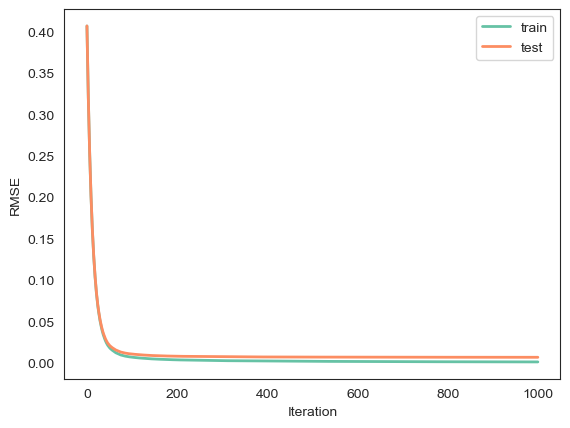

In [7]:
sns.set_style("white")
palette = sns.color_palette("Set2", n_colors=2) 

plt.plot(reg_mod.evals_result()['validation_0']['rmse'], label='train', color=palette[0], linewidth=2)
plt.plot(reg_mod.evals_result()['validation_1']['rmse'], label='test', color=palette[1], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.show()